# Imports

## Basic Stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import math

## sklearn

In [182]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance

## Models

In [3]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# Load CSVs

In [4]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [5]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [6]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

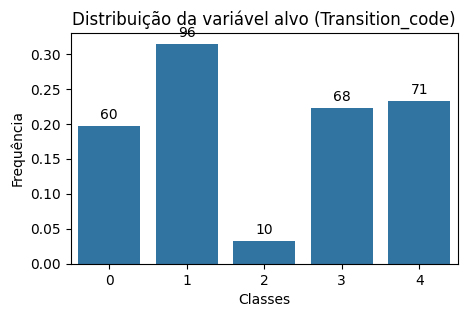

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

# Criação do gráfico
plt.figure(figsize=(5, 3))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

# Adiciona contador em cima de cada barra com a ordem correta
for index, value in enumerate(target_distribution.index):
    ax.text(index, target_distribution[value] + 0.01, f'{target_counts[value]}', ha='center')

plt.show()


## MatPlots

In [8]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [9]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [10]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [11]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [12]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [13]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [14]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [15]:
def main_exploration(df):
    print(df.shape) 

In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

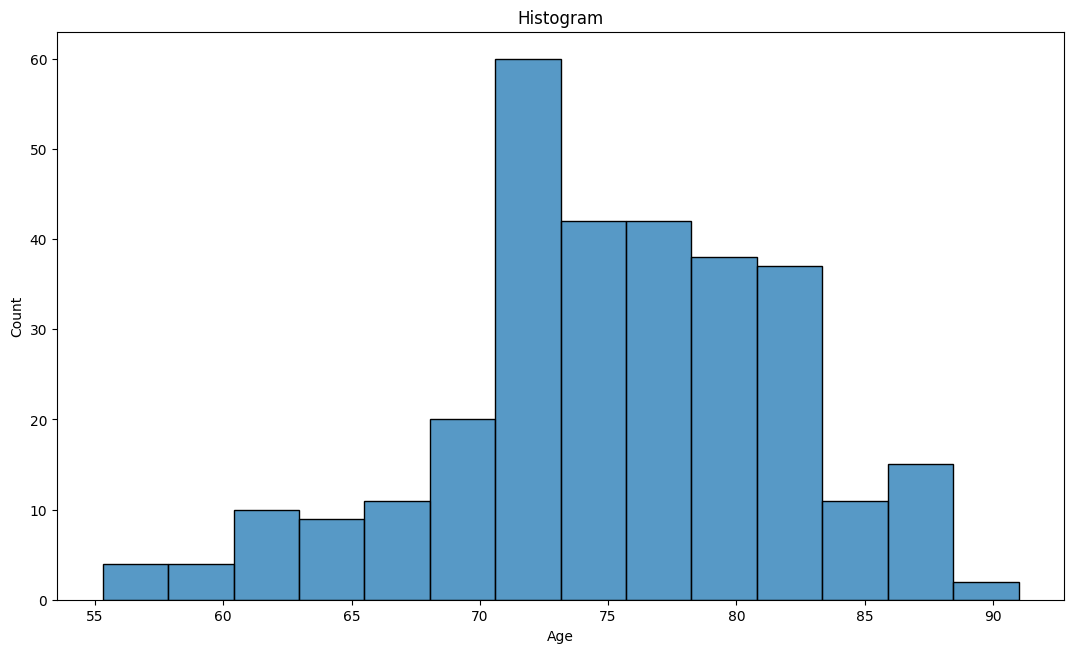

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [17]:
numerical_exploration(train_df)

In [18]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

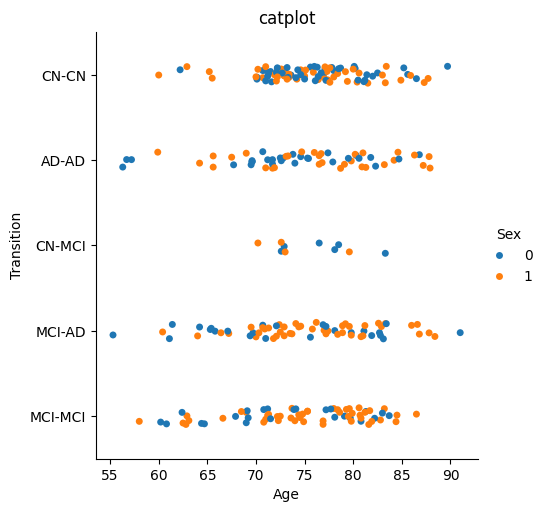

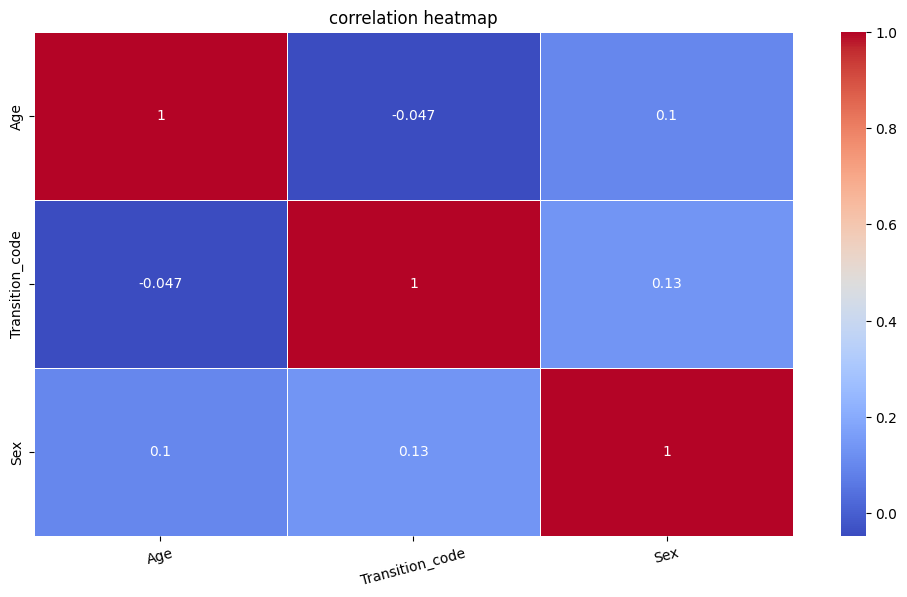

In [19]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

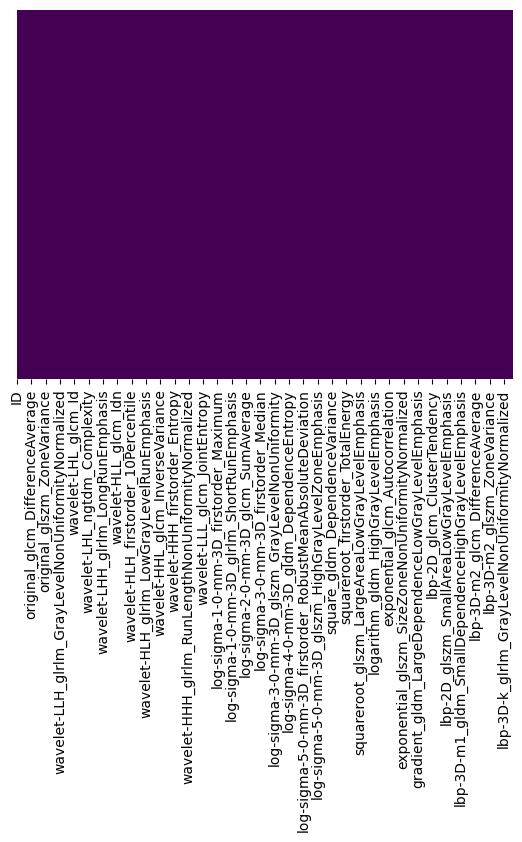

In [20]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [21]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [22]:
diagnostics_configs(train_df)

1
1


In [23]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [24]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [25]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [27]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

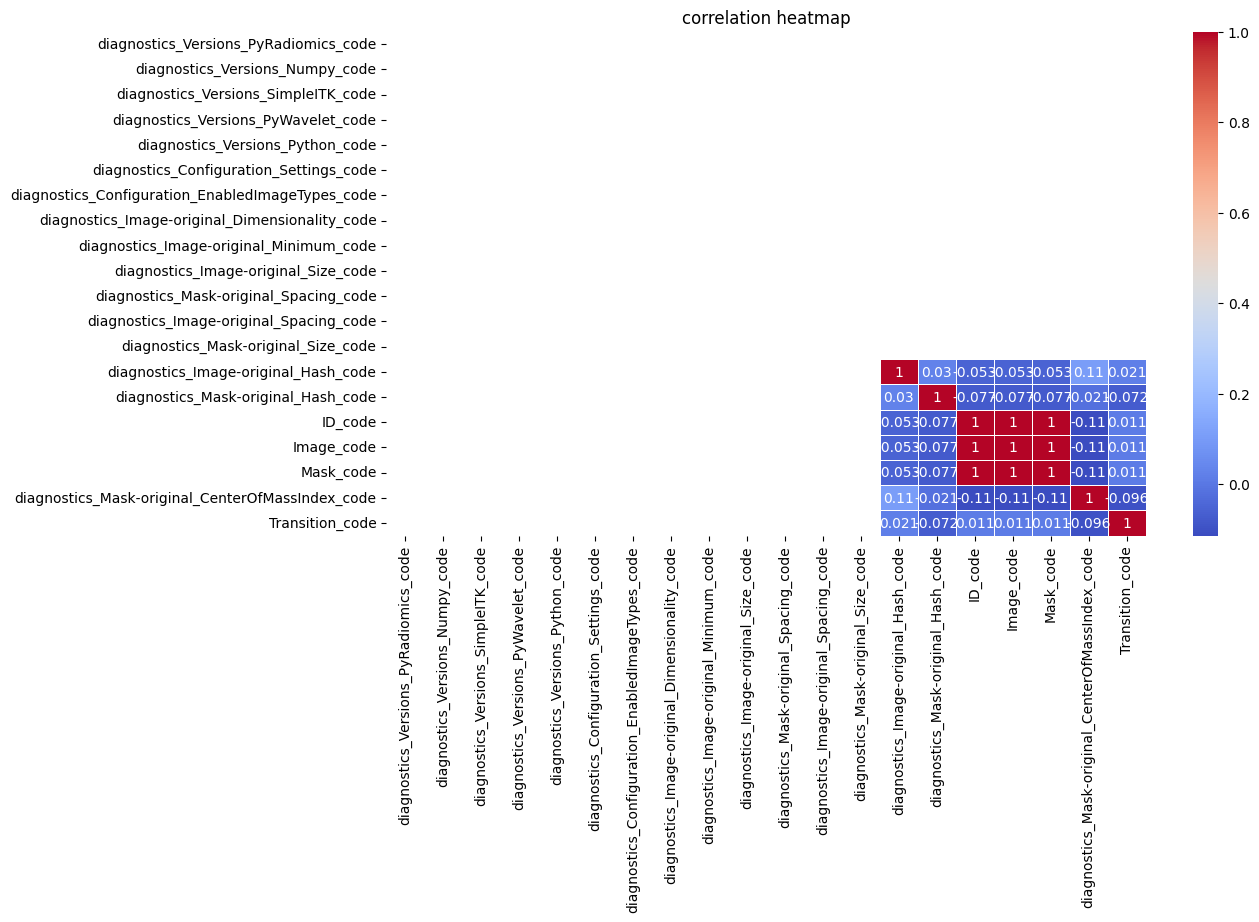

In [28]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

## Correlations

In [29]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


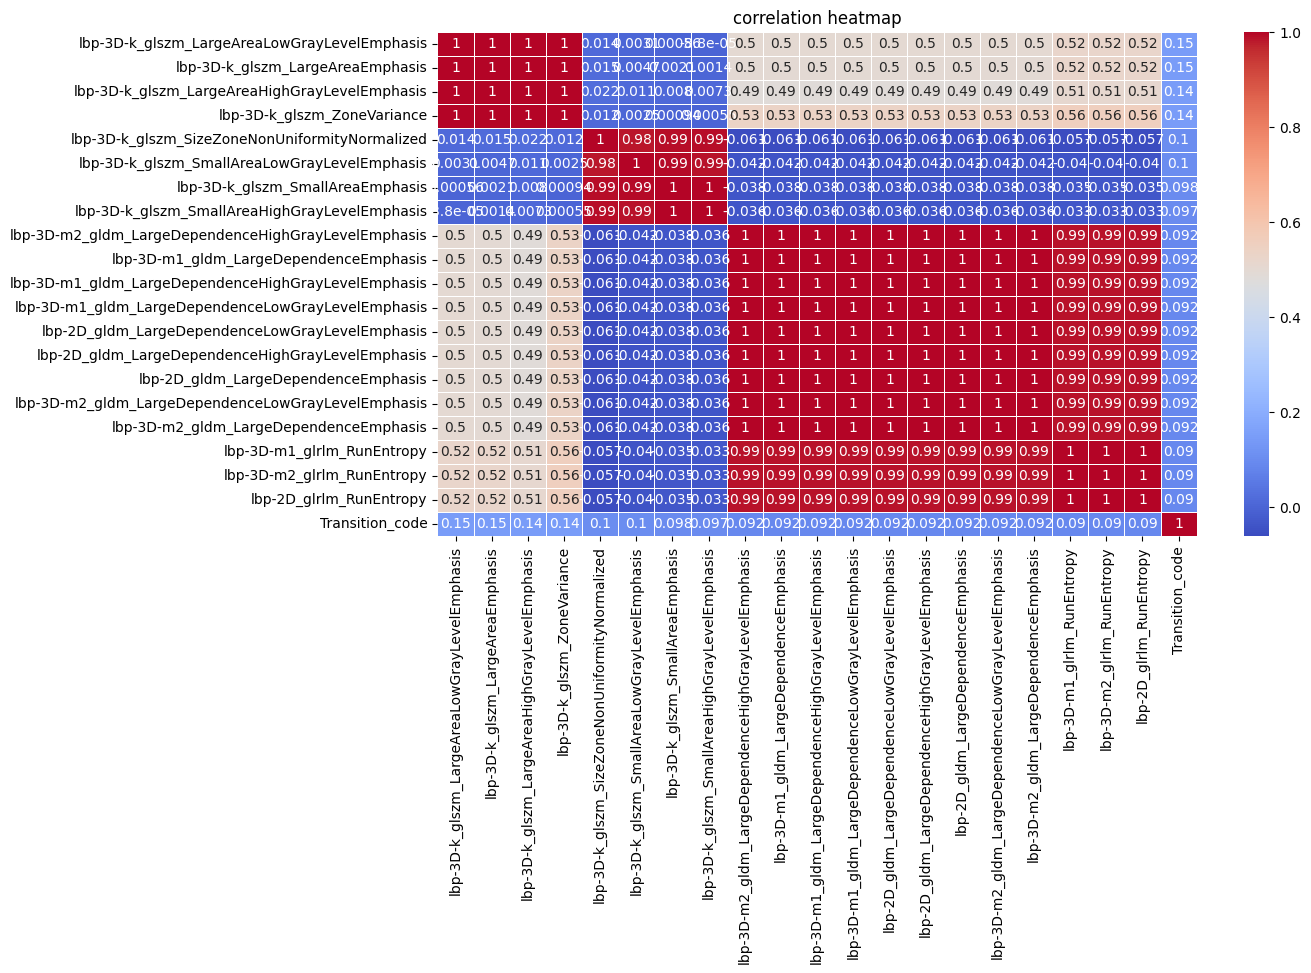

In [30]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Save & Load Data

In [31]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Processing

## Drop Unnecessary Columns

In [32]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Nunique Columns

In [33]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")

## Non Numerical Columns

In [34]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [35]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [36]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [37]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [38]:
main_exploration(train_df)

(305, 2024)


In [39]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [40]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [41]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

## Correlation Analisys

In [42]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [43]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [44]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [45]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]

In [46]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [47]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2023)
(305, 2023)
(100, 2022)


# Testing Phase

In [48]:
def define_X_y(train_df, test_df = pd.DataFrame(),random_state=27):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [49]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(244, 2022)
(61, 2022)


## Params

In [429]:
stacking_model_svm

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimators=[('svm',
                                SVC(C=0.1, cache_size=100,
                                    class_weight='balanced', gamma=0.001,
                                    kernel='linear', random_state=27,
                                    tol=1e-05)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       max_depth=30,
                                                       min_samples_leaf=7,
                                                       min_samples_split=7,
                                                       n_estimators=232,
                                                       random_st...
                                              multi_strategy=None,
                                              n_estimators=250, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...)),
                               ('light',
                                LGBMClassifier(bagging_fraction=0.9,
                                               class_weight='balanced',
                                               learning_rate=0.15, max_depth=5,
                                               min_data_in_leaf=20,
                                               num_leaves=100, random_state=27,
                                               verbose=-1))],
                   final_estimator=LogisticRegression(C=0.1, max_iter=3000,
                                                      random_state=27,
                                                      solver='saga'),
                   n_jobs=-1)

In [430]:
rf_grid_model

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=5, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=80, random_state=27)

### Grid Params

In [431]:
param_grid_rf = {
    'n_estimators': [80, 150, 250, 400],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

param_grid_xgb = {
    'learning_rate': [0.1, 0.15, 0.2,0.25],
    'n_estimators': [80, 150, 250, 400],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [ 0.5, 0.7, 0.8],
    'min_child_weight': [1, 3, 5, 8]
}

param_grid_light = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
    'num_leaves': [20, 40, 60, 80, 100],
    'max_depth': [5, 10, 15, 20],
    'min_data_in_leaf': [5, 10, 20, 30, 60],
    'bagging_fraction': [0.5, 0.7, 0.9, 1.0],
    'class_weight': ['balanced', None]
}

param_grid_svm = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None],
    'degree': [2, 3, 4, 5],
    'tol': [1e-5, 1e-4, 1e-3],
    'cache_size': [100, 200, 300, 500]
}

param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [20, 50, 100, 150, 250, 400],
    'max_depth': [5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3, 4, 6]
}

param_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations': [20, 100, 200, 400],
    'depth': [4, 6, 8, 10, 12, 15],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'border_count': [32, 50, 100, 150, 255],
    'class_weights': [None, 'balanced']  # Para lidar com desbalanceamento
}


### Bayes Params

In [52]:
param_baye_rf = {
    'n_estimators': (80, 400),
    'max_depth': (5, 35),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 8),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}

param_baye_xgb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (80, 400),
    'max_depth': (5, 30),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.3, 0.8),
    'min_child_weight': (1, 8),
}

param_baye_gb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (20, 400),
    'max_depth': (5, 20),
    'subsample': (0.4, 1.0),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 6),
}

param_baye_cat = {
    'learning_rate': (0.01, 0.3),       
    'iterations': (20, 400),         
    'depth': (4, 15),                  
    'l2_leaf_reg': (1, 10),              
    'border_count': (32, 255)
}

param_baye_light = {
    'learning_rate': (0.05, 0.3),     
    'num_leaves': (20, 100), 
    'max_depth': (5, 20),   
    'min_data_in_leaf': (5, 60),  
    'bagging_fraction': (0.3, 1.0)      
}

param_baye_svm = {
    'C': (0.1, 100),  # Intervalo para o parâmetro C
    'gamma': (0.001, 1),  # Intervalo para gamma
    'kernel': (0, 1),  # 0 para linear, 1 para rbf
    'class_weight': (0, 1),  # 0 para None, 1 para 'balanced'
    'degree': (2, 5),  # Intervalo para o grau do polinômio (para kernel polinomial)
    'tol': (1e-5, 1e-1),  # Intervalo para a tolerância
    'cache_size': (100, 500),  # Intervalo para o tamanho do cache
}

## Models

### SVM

In [432]:
def svm_train_model(x_train,y_train):
    model = SVC(random_state=27)
    model.fit(x_train,y_train)

    return model

# Grid Model
def svm_grid_train_model(x_train,y_train, param_grid=param_grid_svm):
    model = SVC(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

def objective_svm(C, gamma, kernel, class_weight, degree, tol, cache_size):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'C': C,
        'gamma': 'scale' if round(gamma) == 0 else gamma,  # 'scale' ou um valor float de gamma
        'kernel': 'linear' if round(kernel) == 0 else 'rbf',  # 'linear' ou 'rbf'
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'degree': int(degree) if round(kernel) == 1 else 3,  # Degree apenas para kernel polinomial
        'tol': tol,
        'cache_size': cache_size,  # Cache size em MB
        'random_state': 27
    }
    
    model = SVC(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy').mean()  # Troque "scorer" por "accuracy"
    return score

def svm_baye_train_model(x_train, y_train, param_baye=param_baye_svm):
    svm_bo = BayesianOptimization(
        f=objective_svm,
        pbounds=param_baye,
        random_state=27,
    )
    
    svm_bo.maximize(init_points=7, n_iter=45)

    best_params = svm_bo.max['params']

    gamma = 'scale' if round(best_params["gamma"]) == 0 else best_params["gamma"]
    kernel = 'linear' if round(best_params["kernel"]) == 0 else 'rbf'
    best_params_updated = {
        'C': best_params['C'],
        'gamma': gamma,
        'kernel': kernel,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'degree': int(best_params['degree']) if kernel == 'rbf' else 3,  # Degree só para kernel 'rbf'
        'tol': best_params['tol'],
        'cache_size': best_params['cache_size'],
        'random_state': 27
    }

    print(best_params_updated)

    model = SVC(**best_params_updated)
    model.fit(x_train, y_train)

    svm_results = pd.DataFrame(svm_bo.res)
    svm_results.sort_values(by="target", ascending=False, inplace=True)

    return model, svm_results, svm_bo.max

### RandomForest

In [433]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)
    
    grid_search = RandomizedSearchCV(model, param_grid_rf, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 27
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=27,
    )
    
    rf_bo.maximize(init_points=7, n_iter=45)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 27
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### XGBoost

In [434]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27)
    model.fit(x_train,y_train)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_xgb, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)
    

    return grid_search.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 27
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=27,
    )
    
    xgb_bo.maximize(init_points=7, n_iter=30)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 27
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### GradientBoost

In [394]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb=param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 27
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye=param_baye_gb):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    gb_bo.maximize(init_points=7, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 27 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

## LightGBM

In [435]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1)
    model.fit(x_train,y_train)

    return model

# Grid Model
def light_grid_train_model(x_train,y_train, param_grid=param_grid_light):
    model = lgb.LGBMClassifier(verbose=-1,random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_light, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_train_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    light_bo.maximize(init_points=7, n_iter=45)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

## CatBoosting

In [396]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye=param_baye_cat):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Logistic Regression L2

In [397]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

## Voting Ensemble

In [398]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

## Stacking Ensemble

In [455]:
def stacking_ensemble(x_train,y_train,estimators):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    #param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    #grid_search = RandomizedSearchCV(LogisticRegression(max_iter=3000, random_state=27, solver='saga'),n_iter=5, param_grid, cv=cv,scoring=scorer)
    #grid_search.fit(x_train, y_train)

    #best_estimator = grid_search.best_estimator_
    
    model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv, n_jobs=-1)
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [366]:
def apply_basic_models(x_train,y_train,x_test,y_test, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=0, light=1,svm=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None  

    if svm:
        svm_model = svm_train_model(x_train,y_train)
        results["SVM"] = [svm_model,None]
    else:
        svm_model = None 

    if len(x_train) != 305:
        models_comparison(results,title,x_train=x_train,y_train=y_train)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model, svm_model

## Models Comparison

In [367]:
def models_comparison(results, title, x_train, y_train,n_repeats=5):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=27)
    
    for result in results:
        if results[result][1] is None:
            # Calcular F1 Score usando cross-validation
            f1_scores = cross_val_score(
                results[result][0], x_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="macro")
            )
            results[result][1] = f1_scores.mean()
            print(f"F1 Macro Score em {result}: {results[result][1]} ± {round(f1_scores.std(),3)}")
        
        else:
            print(f"F1 Macro Score em {result}: {results[result][1]}")
        
    
    # Criar gráfico
    models_score = plt.figure(figsize=(6, 3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod, f1, color="lightblue", width=0.5)
    plt.xlabel("Modelo")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## MultiClass Analysis

In [445]:
def class_accuracy(model,x_test,y_test):
    # matriz de confusão
    conf_matrix = confusion_matrix(y_test, stacking_model.predict(x_test))
    
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predict")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()

    # grafico de barras com a percentagem de acertos
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_accuracies_percentage = class_accuracies * 100  
    total_per_class = np.sum(conf_matrix, axis=1) 
    correct_per_class = np.diag(conf_matrix) 
    
    plt.figure(figsize=(7, 4))
    classes = np.unique(y_test)
    plt.bar(classes, class_accuracies_percentage, color='skyblue', alpha=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Class")
    plt.ylim(0, 100) 
    

    for i, v in enumerate(class_accuracies_percentage):
        text = f"{correct_per_class[i]}/{total_per_class[i]} ({v:.1f}%)"
        plt.text(classes[i], v + 2, text, ha='center', fontsize=10)
    
    plt.show()

## Models Tester

F1 Macro Score em RandomForest: 0.2594590131728912
F1 Macro Score em XGBoost: 0.28181355795906876
F1 Macro Score em LightGBM: 0.3334775374426472
F1 Macro Score em SVM: 0.27796276787573826


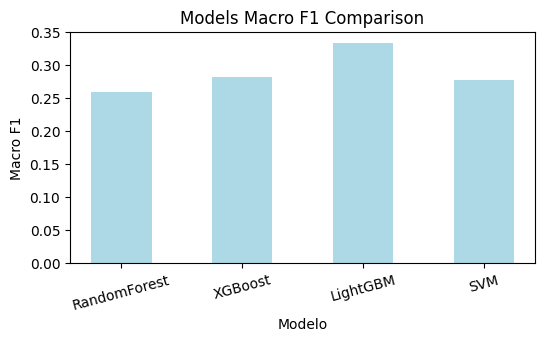

In [65]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model, svm_model = apply_basic_models(x_train,y_train,x_test,y_test)

## Feature Importance Analysis

### Permutation Importance

In [66]:
#print("rf...")
#pi_rf_result = permutation_importance(rf_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("xgb...")
#pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("gradient...")
#pi_gradient_result = permutation_importance(gradient_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1)
#print("catboost...")
#pi_cat_result = permutation_importance(cat_model, x_test, y_test, n_repeats=5, random_state=27)
#print("light...")
#pi_light_result = permutation_importance(light_model, x_test, y_test, n_repeats=5, random_state=27)

#pi_rf_result = load_stuff("Permutations/pi_rf_result.pkl")
pi_xgb_result = load_stuff("Permutations/pi_xgb_result.pkl")
#pi_gradient_result = load_stuff("Permutations/pi_gradient_result.pkl")
#pi_cat_result = load_stuff("Permutations/pi_cat_result.pkl")
pi_light_result = load_stuff("Permutations/pi_light_result.pkl")

In [67]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

(244, 2022)
(61, 2022)


## SHAP Analysis

In [68]:
X_shap = corr_train_df.drop("Transition_code", axis=1)  # Features
y_shap = corr_train_df["Transition_code"]

In [69]:
def get_shap_mean_values(shap_values, X, threshold=0):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values  # É um ndarray

    # Calcula a média dos valores absolutos dos SHAP values
    feature_shap = np.abs(shap_array).mean(axis=(0, 2))

    # Cria o DataFrame com as importâncias médias dos SHAP values
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance": feature_shap
    }).sort_values(by="importance", ascending=False)

    # Filtra as features com importância menor ou igual ao threshold
    zero_shap_importance_features_dic = feature_shap_importance_df[
        feature_shap_importance_df["importance"] <= threshold
    ]

    return zero_shap_importance_features_dic

In [70]:
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")
#shap_values_rf = load_stuff("SHAP_Values/shap_values_rf.pkl")
#shap_values_cat = load_stuff("SHAP_Values/shap_values_cat.pkl")
shap_values_light = load_stuff("SHAP_Values/shap_values_light.pkl")

### Global

In [ ]:
#X_shap_pool = Pool(X_shap)
#explainer = shap.TreeExplainer(cat_model)
#shap_values_cat = explainer.shap_values(X_shap_pool)

In [ ]:
#explainer = shap.Explainer(xgb_model,X_shap)
#shap_values_xgb = explainer(X_shap)

In [ ]:
#explainer = shap.Explainer(light_model,X_shap)
#shap_values_light = explainer(X_shap)

In [ ]:
#explainer = shap.Explainer(rf_model,X_shap)
#shap_values_rf = explainer(X_shap,check_additivity=False)

In [ ]:
shap_importances_rf = get_shap_mean_values(shap_values_rf,X_shap,0.0)
print(len(shap_importances_rf))

In [ ]:
shap_importances_xgb = get_shap_mean_values(shap_values_xgb,X_shap,0.01)
print(len(shap_importances_xgb))

In [ ]:
shap_importances_cat = get_shap_mean_values(shap_values_cat,X_shap,0.00)
print(len(shap_importances_cat))

In [ ]:
show_histogram(shap_values_xgb)

In [ ]:
print(len(set(shap_columns_rf) & set(shap_columns_rf) & set(shap_columns_gradient)))

In [ ]:
n_features = shap_values.shape[1]
n_features_per_plot = 10

In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.plots.heatmap(selected_shap_values)
    
    plt.show()


In [ ]:
for i in range(0, n_features, n_features_per_plot):
    selected_shap_values = shap_values[:, i:i + n_features_per_plot, 1]
    
    shap.summary_plot(selected_shap_values, feature_names=positive_columns_xgb[i:i + n_features_per_plot], show=False)
    
    plt.show()


### Local

In [ ]:
idx = [3, 48, 123, 254, 300, 31, 34, 12, 156, 7, 304, 299, 197, 100, 200, 50]
print(len(idx))

global_shap_values = without_null_imp_train_df.drop("Transition_code",axis=1).mean()

top_positive_features = global_shap_values.nlargest(0)
top_negative_features = global_shap_values.nsmallest(20)


selected_features = pd.concat([top_positive_features, top_negative_features])

fig, ax = plt.subplots(8, 2, figsize=(18, 72))

for i in range(16):
    shap_values = without_null_imp_train_df.iloc[idx[i]]
    
    instance_shap_values = shap_values[selected_features.index]
    
    row, col = divmod(i, 2)
    ax[row, col].bar(instance_shap_values.index, instance_shap_values.values, 
                     color=['#1f77b4' if v > 0 else '#ff7f0e' for v in instance_shap_values.values])
    ax[row, col].set_title(f'SHAP Values of Instance {idx[i]}')
    ax[row, col].tick_params(axis='x', rotation=90)
    ax[row, col].set_xlabel("Features")
    ax[row, col].set_ylabel("SHAP Value")

plt.tight_layout()
plt.show()


In [ ]:
print(top_negative_features.keys())

## SHAP PermImportance Combined

In [197]:
def combine_shap_perm(X, y, shap_values, perm_importance_values, threshold_mean=0, threshold_std=0, threshold_importance=0):
    shap_array = getattr(shap_values, 'values', shap_values)

    # Calcula métricas SHAP
    shap_mean = shap_array.mean(axis=(0, 2))
    shap_std = shap_array.std(axis=(0, 2))

    # Combina importâncias SHAP e permutação em um df
    importance_df = pd.DataFrame({
        "feature": X.columns,
        "shap_mean": shap_mean,
        "shap_std": shap_std,
        "perm_importance": perm_importance_values.importances_mean
    })

    # Identifica features a serem descartadas
    discard_features = importance_df[
        (importance_df["shap_mean"] <= threshold_mean) & 
        (importance_df["shap_std"] <= threshold_std) & 
        (importance_df["perm_importance"] <= threshold_importance)
    ]["feature"].tolist()

    return discard_features


In [352]:
discard_xgb = combine_shap_perm(X_shap,y_shap,shap_values_xgb,pi_xgb_result,threshold_mean=0.02,threshold_std=0.0162,threshold_importance=0.02)

In [353]:
print(len(discard_xgb))

1761


# Models Tester

In [446]:
shap_train_df = corr_train_df.drop(columns=discard_xgb)
shap_train_df.to_csv("../Dataset/new_db.csv",index=False)
shap_control_df = corr_control_df.drop(columns=discard_xgb)
shap_test_df = corr_test_df.drop(columns=discard_xgb)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,random_state=27)
main_exploration(x_train)
main_exploration(x_test)

(244, 261)
(61, 261)


## Basic Models

F1 Macro Score em RandomForest: 0.3325496225365355 ± 0.049
F1 Macro Score em XGBoost: 0.36014779704518524 ± 0.057
F1 Macro Score em LightGBM: 0.4028221007443083 ± 0.065
F1 Macro Score em SVM: 0.31909536010832895 ± 0.047


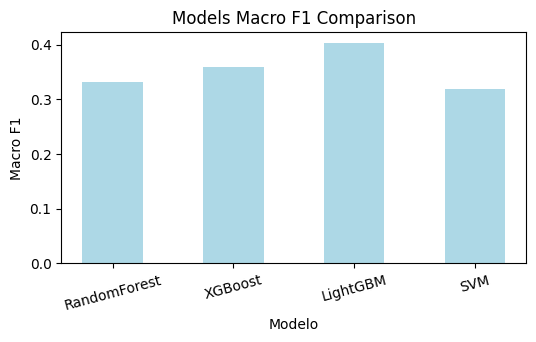

In [370]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model,svm_model = apply_basic_models(x_train,y_train,x_test,y_test)

F1 Macro Score em StackingBasic: 0.35748721462087996 ± 0.067
F1 Macro Score em StackingGrid: 0.3569460522866572


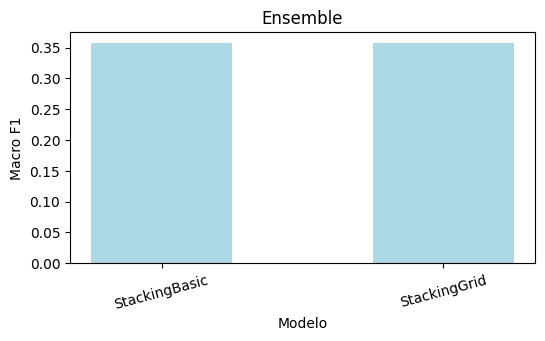

In [456]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasic"] = [stacking_model,None]
#stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
#results["StackingBasicSVM"] = [stacking_m|odel_svm,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=4)

F1 Macro Score em StackingBasic: 0.35748721462087996
F1 Macro Score em StackingGrid: 0.37223149226696817 ± 0.065


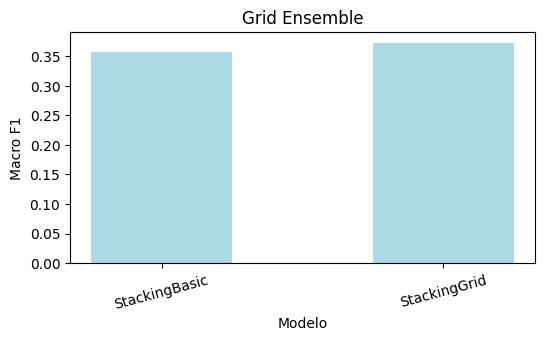

In [457]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
light_ensemble = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_ensemble = SVC(**svm_grid_model.get_params())

stacking_model_grid = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])


results["StackingGrid"] = [stacking_model_grid,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=4)

In [ ]:
class_accuracy(stacking_model,x_test,y_test)

In [ ]:
class_accuracy(stacking_model_grid,x_test,y_test)

## BayesOptimizer Tuning

In [387]:
def bayes_visualization(params,bayes_results,best_hyperparameters):
    param_names = list(params.keys())

    cols = 3
    rows = math.ceil(len(param_names)/cols)
    
    fig, axes = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, param in enumerate(param_names):
        if param != "target":
            ax = axes[i//3, i%3]
            ax.plot(bayes_results['params'].apply(lambda x: x[param]),
                bayes_results['target'], 'bo-', lw=1, markersize=4)
            ax.set_title(f'Optimization of {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('F1 Macro Score')
     
            best_value = best_hyperparameters['params'][param]
            ax.plot(best_value, best_hyperparameters['target'], 'yo', markersize=6)
            
    for i in range(len(param_names), 6):
        fig.delaxes(axes.flatten()[i])
 
    plt.show()

|   iter    |  target   | bootstrap | class_... | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.3387    | 0.4257    | 0.8146    | 27.06     | 7.076     | 5.067     | 393.4     |
| 2         | 0.325     | 0.8932    | 0.2097    | 27.25     | 5.642     | 9.094     | 354.6     |
| 3         | 0.3304    | 0.7493    | 0.8701    | 10.6      | 3.279     | 4.983     | 334.0     |
| 4         | 0.3465    | 0.1511    | 0.1699    | 7.435     | 3.136     | 8.266     | 132.1     |
| 5         | 0.3254    | 0.07064   | 0.7011    | 10.43     | 5.192     | 5.322     | 244.3     |
| 6         | 0.3542    | 0.2207    | 0.7256    | 30.48     | 7.502     | 7.888     | 232.5     |
| 7         | 0.324     | 0.4929    | 0.5945    | 7.281     | 1.822     | 9.732     | 266.7     |
| 8         | 0.3372    | 0.8142    | 0.7556    | 31.23     | 6.62      | 7.305     | 231.5     |
| 9         | 0.3256

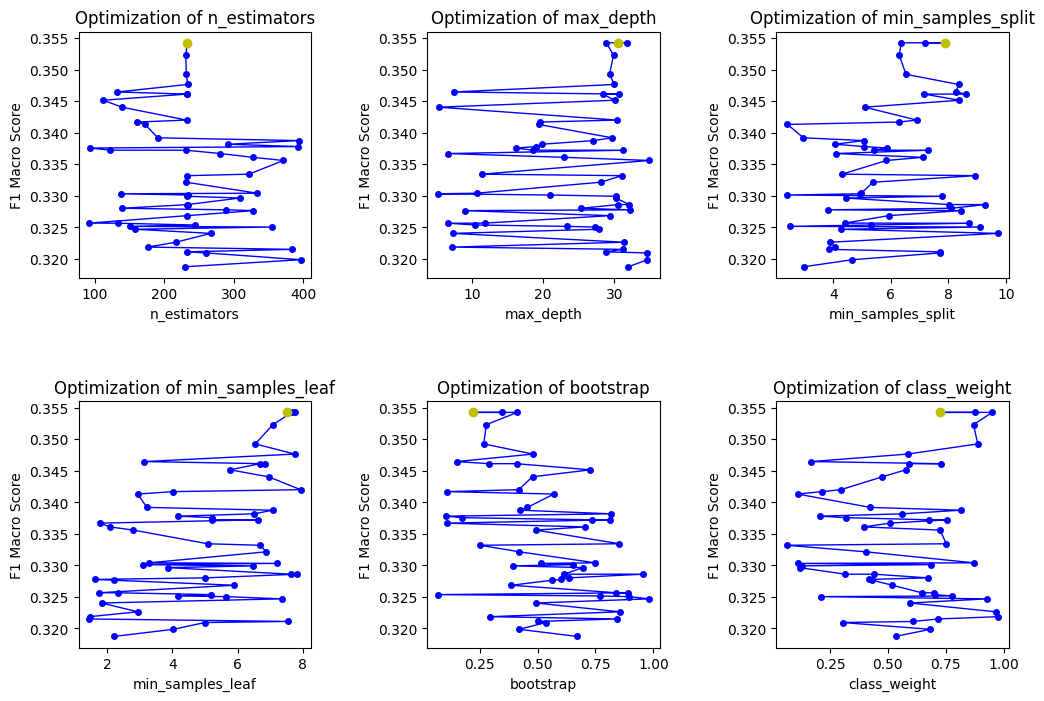

F1 Macro Score em RandomForestBaye: 0.35210069381986725 ± 0.055


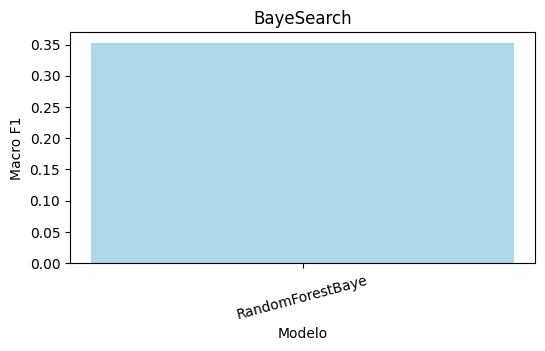

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.3622    | 0.5129    | 0.1648    | 23.38     | 7.076     | 202.7     | 0.9897    |
| 2         | 0.3634    | 0.7466    | 0.04985   | 23.55     | 5.642     | 363.8     | 0.929     |
| 3         | 0.3813    | 0.6746    | 0.1753    | 9.669     | 3.279     | 199.3     | 0.8969    |
| 4         | 0.3617    | 0.3755    | 0.04229   | 7.029     | 3.136     | 330.7     | 0.5815    |
| 5         | 0.3666    | 0.3353    | 0.1432    | 9.524     | 5.192     | 212.9     | 0.7568    |
| 6         | 0.3741    | 0.4103    | 0.1479    | 26.24     | 7.502     | 315.5     | 0.7383    |
| 7         | 0.3809    | 0.5464    | 0.123     | 6.901     | 1.822     | 389.3     | 0.7917    |
| 8         | 0.3561    | 0.633     | 0.04823   | 6.858     | 1.423     | 389.0     | 0.9067    |
| 9         | 0.3665

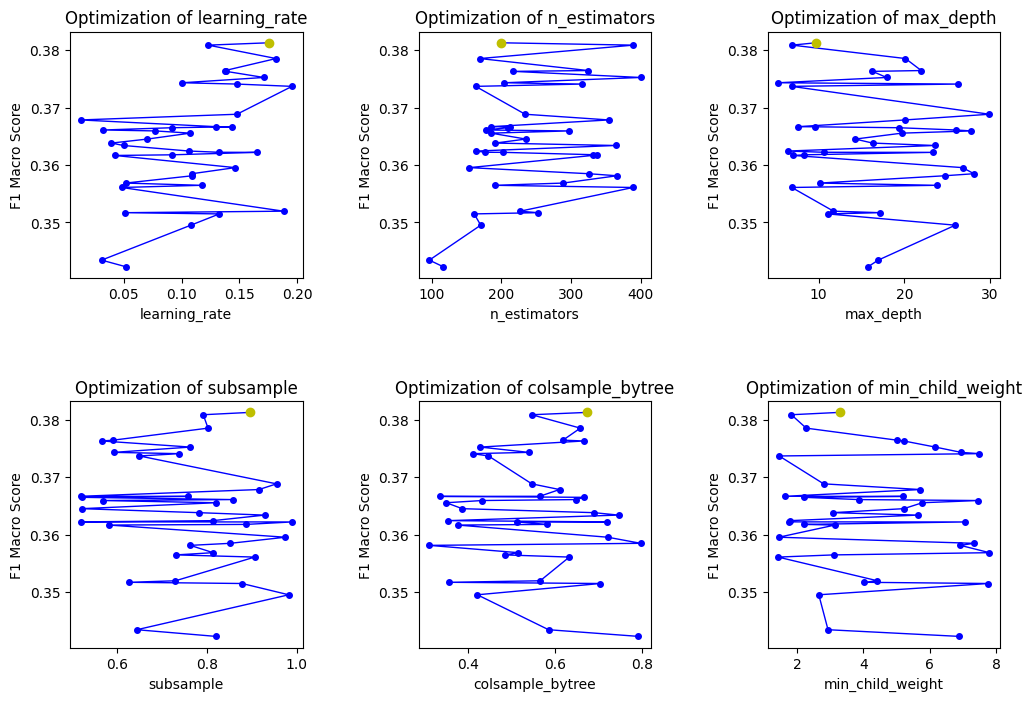

F1 Macro Score em RandomForestBaye: 0.35210069381986725
F1 Macro Score em XGBoostBaye: 0.3689821287071184 ± 0.053


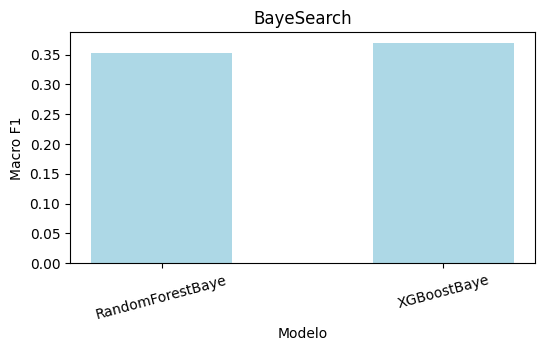

|   iter    |  target   | baggin... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
| 1         | 0.3593    | 0.598     | 0.2536    | 16.03     | 52.74     | 50.67     |
| 2         | 0.3648    | 0.9856    | 0.2733    | 8.146     | 45.8      | 73.05     |
| 3         | 0.365     | 0.9208    | 0.2645    | 16.24     | 52.86     | 34.94     |
| 4         | 0.4057    | 0.5279    | 0.1432    | 16.91     | 13.31     | 33.6      |
| 5         | 0.4022    | 0.3568    | 0.1263    | 16.75     | 13.96     | 25.65     |
| 6         | 0.3863    | 0.7907    | 0.09524   | 13.98     | 27.84     | 61.09     |
| 7         | 0.3614    | 0.4545    | 0.2314    | 17.74     | 56.09     | 78.88     |
| 8         | 0.4046    | 0.5888    | 0.1166    | 17.78     | 12.75     | 33.98     |
| 9         | 0.3716    | 0.5036    | 0.1823    | 5.144     | 5.083     | 52.18     |
| 10        | 0.3849    | 0.9611    | 0.09092   | 5.16

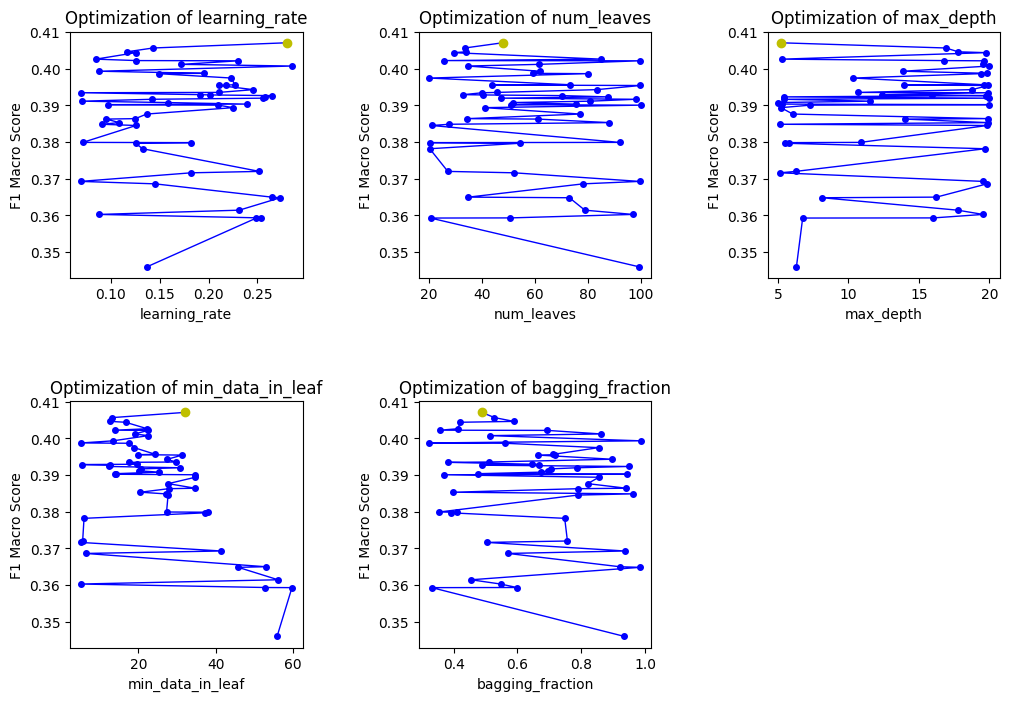

F1 Macro Score em RandomForestBaye: 0.35210069381986725
F1 Macro Score em XGBoostBaye: 0.3689821287071184
F1 Macro Score em LightBoostBaye: 0.4070980308394068 ± 0.066


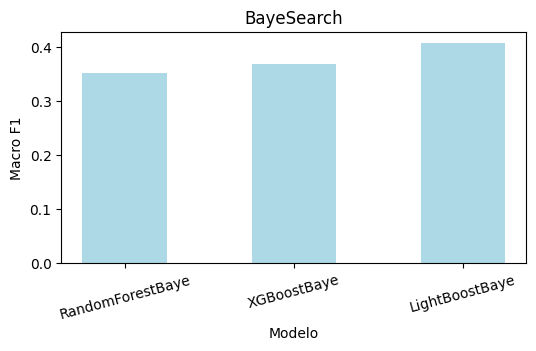

|   iter    |  target   |     C     | cache_... | class_... |  degree   |   gamma   |  kernel   |    tol    |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.4597    | 42.63     | 425.8     | 0.7354    | 4.604     | 0.384     | 0.9795    | 0.08932   |
| 2         | 0.3156    | 21.05     | 396.7     | 0.6631    | 4.66      | 0.8582    | 0.7493    | 0.08702   |
| 3         | 0.4458    | 18.76     | 230.2     | 0.3729    | 4.381     | 0.1519    | 0.1699    | 0.008126  |
| 4         | 0.445     | 30.59     | 413.3     | 0.1629    | 2.212     | 0.7014    | 0.181     | 0.0599    |
| 5         | 0.3156    | 41.58     | 305.4     | 0.2207    | 4.177     | 0.8496    | 0.9289    | 0.0736    |
| 6         | 0.4573    | 47.71     | 297.2     | 0.5945    | 2.228     | 0.1184    | 0.9665    | 0.05834   |
| 7         | 0.4458    | 9.333     | 105.5     | 0.8369    | 4.744     | 0.7049    | 0.387     | 0.07057   |
| 8       

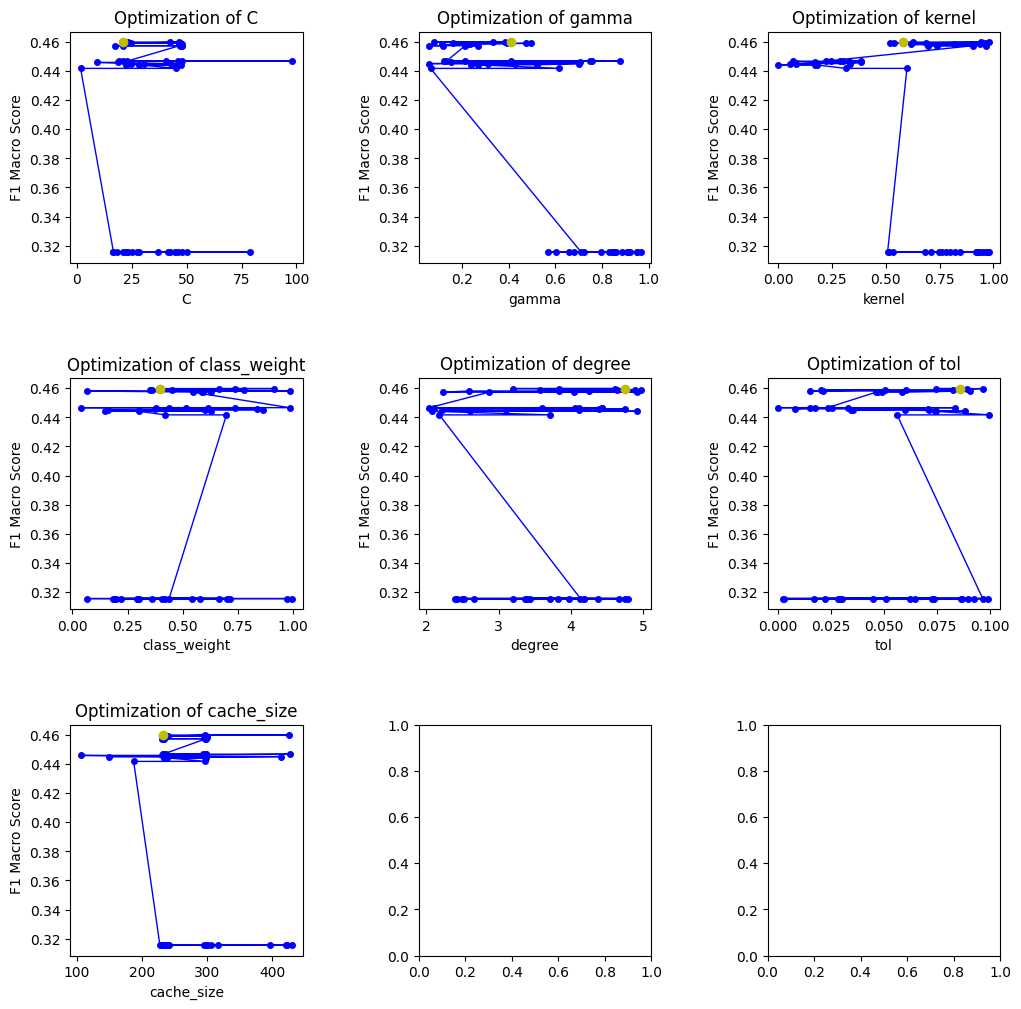

F1 Macro Score em RandomForestBaye: 0.35210069381986725
F1 Macro Score em XGBoostBaye: 0.3689821287071184
F1 Macro Score em LightBoostBaye: 0.4070980308394068
F1 Macro Score em SVMBaye: 0.34004736329860674 ± 0.052


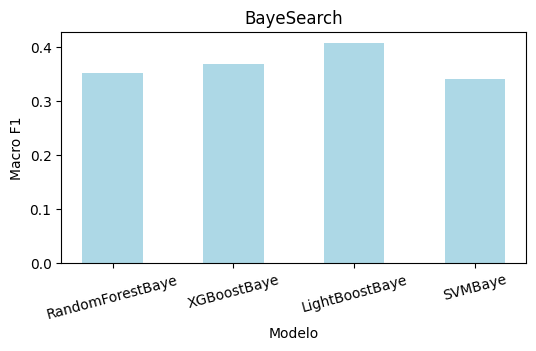

In [400]:
results = {}

rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
results["RandomForestBaye"] = [rf_baye_model,None]
bayes_visualization(param_baye_rf, rf_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
bayes_visualization(param_baye_xgb, xgb_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

light_baye_model, light_baye_results, best_params = light_baye_train_model(x_train,y_train)
results["LightBoostBaye"] = [light_baye_model,None]
bayes_visualization(param_baye_light, light_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

svm_baye_model, svm_baye_results, best_params = svm_baye_train_model(x_train,y_train)
results["SVMBaye"] = [svm_baye_model,None]
bayes_visualization(param_baye_svm, svm_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

In [401]:
rf_ensemble = RandomForestClassifier(**rf_baye_model.get_params())

In [402]:
xgb_ensemble = XGBClassifier(**xgb_baye_model.get_params())

In [403]:
light_ensemble = lgb.LGBMClassifier(**light_baye_model.get_params())

In [404]:
svm_ensemble = SVC(**svm_baye_model.get_params())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Macro Score em RandomForestBaye: 0.35210069381986725
F1 Macro Score em XGBoostBaye: 0.3689821287071184
F1 Macro Score em LightBoostBaye: 0.4070980308394068
F1 Macro Score em SVMBaye: 0.34004736329860674
F1 Macro Score em StackingBaye: 0.3497779970514643 ± 0.067
F1 Macro Score em StackingBayeSVM: 0.34263562361012384 ± 0.065


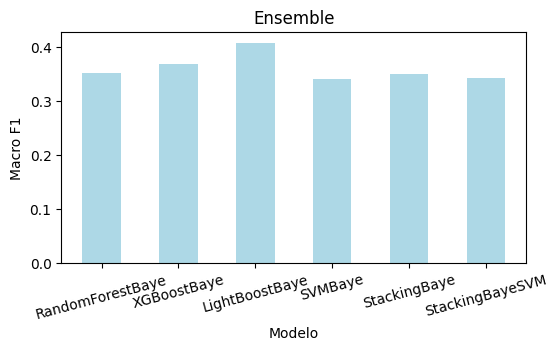

In [405]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBaye"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBayeSVM"] = [stacking_model_svm,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

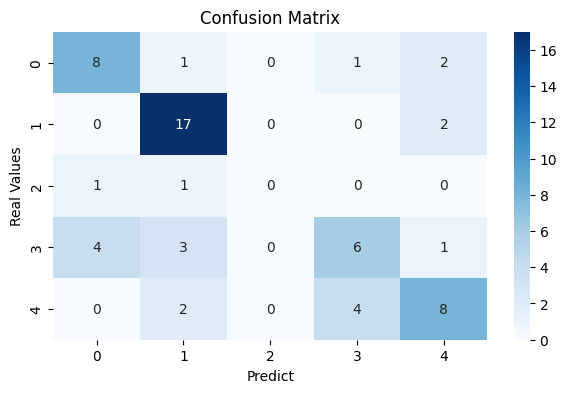

In [406]:
class_accuracy(stacking_model_svm,x_test,y_test)

## GridSearch Tuning

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 5, 'class_weight': 'balanced_subsample', 'bootstrap': False}
F1 Macro Score em RandomForestGrid: 0.37753740721766077 ± 0.075


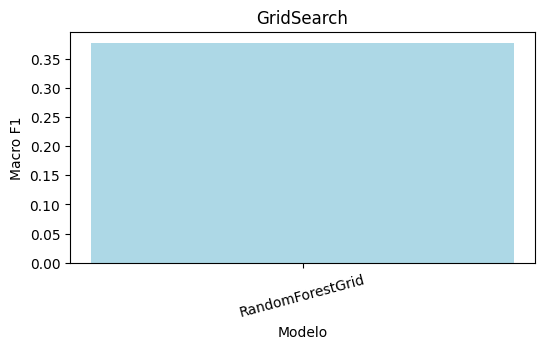

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
F1 Macro Score em RandomForestGrid: 0.37753740721766077
F1 Macro Score em XGBoostGrid: 0.38808136147083355 ± 0.064


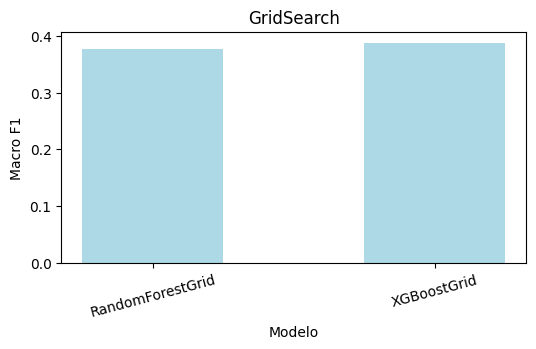

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'num_leaves': 100, 'min_data_in_leaf': 20, 'max_depth': 5, 'learning_rate': 0.15, 'class_weight': 'balanced', 'bagging_fraction': 0.9}
F1 Macro Score em RandomForestGrid: 0.37753740721766077
F1 Macro Score em XGBoostGrid: 0.38808136147083355
F1 Macro Score em lightGrid: 0.42118470864349666 ± 0.077


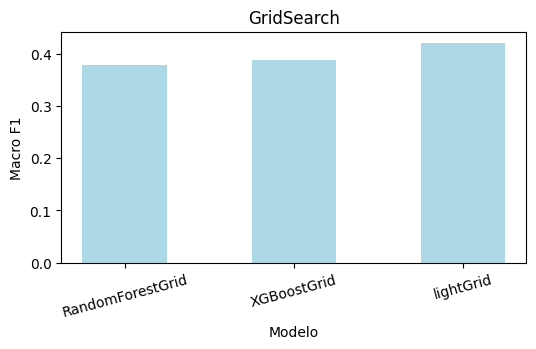

Fitting 25 folds for each of 200 candidates, totalling 5000 fits
{'tol': 1e-05, 'kernel': 'linear', 'gamma': 0.001, 'degree': 3, 'class_weight': 'balanced', 'cache_size': 100, 'C': 0.1}
F1 Macro Score em RandomForestGrid: 0.37753740721766077
F1 Macro Score em XGBoostGrid: 0.38808136147083355
F1 Macro Score em lightGrid: 0.42118470864349666
F1 Macro Score em SVMGrid: 0.36741805874894246 ± 0.074


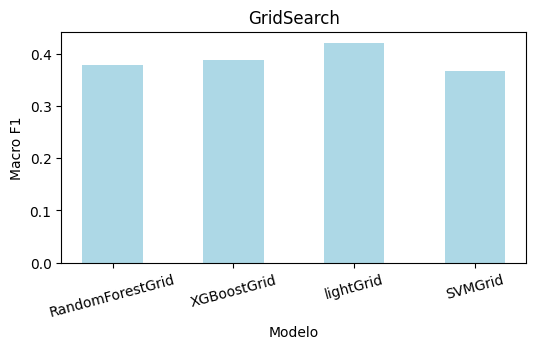

In [437]:
results = {}
rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

light_grid_model = light_grid_train_model(x_train,y_train)
results["lightGrid"] = [light_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

svm_grid_model = svm_grid_train_model(x_train,y_train)
results["SVMGrid"] = [svm_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

In [ ]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
light_ensemble = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_ensemble = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
#stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])

results["StackingGrid"] = [stacking_model,None]
#results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

F1 Macro Score em StackingBasic: 0.35748721462087996


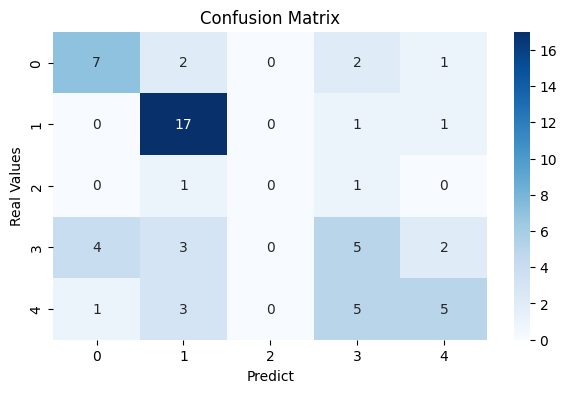

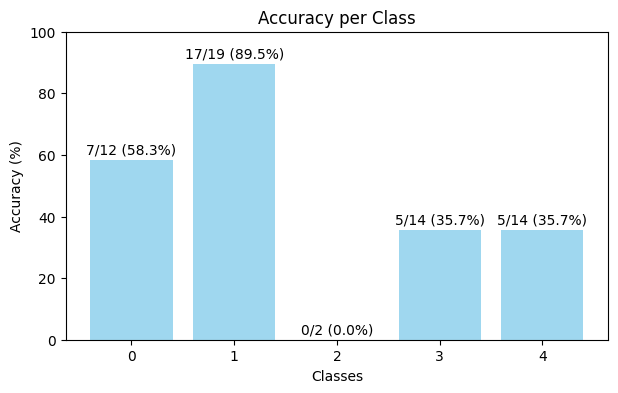

In [444]:
class_accuracy(stacking_model,x_test,y_test)

## Ensemble with Best Models

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Macro Score em RandomForestGrid: 0.35104028712116475
F1 Macro Score em XGBoostGrid: 0.3875466023858185
F1 Macro Score em lightGrid: 0.42118470864349666
F1 Macro Score em SVMGrid: 0.36741805874894246
F1 Macro Score em StackingGrid: 0.3725193879446633 ± 0.061
F1 Macro Score em StackingGridSVM: 0.36245803067441856 ± 0.055


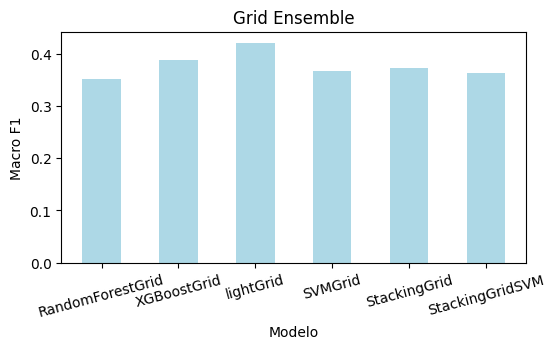

In [410]:
rf_best_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_best_model = XGBClassifier(**xgb_grid_model.get_params())
light_best_model = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_best_model = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_best_model),("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])

results["StackingGrid"] = [stacking_model,None]
results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

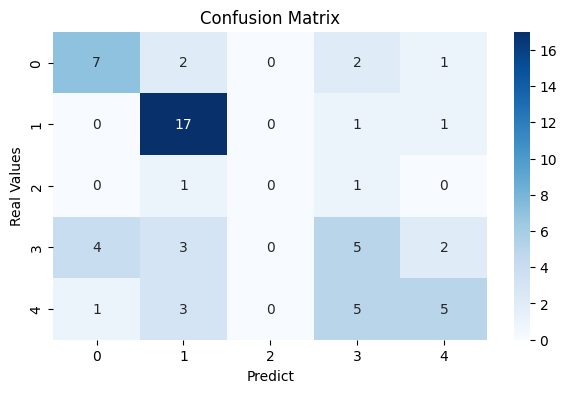

In [418]:
class_accuracy(stacking_model,x_test,y_test)

# Get Preds

In [411]:
shap_train_df = corr_train_df.drop(columns=discard_xgb)
shap_control_df = corr_control_df.drop(columns=discard_xgb)
shap_test_df = corr_test_df.drop(columns=discard_xgb)
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,shap_test_df,random_state=60)
main_exploration(x_train)
main_exploration(x_test)

(305, 261)
(100, 261)


In [420]:
rf_params = rf_model.get_params()
xgb_params = xgb_model.get_params()
light_params = light_model.get_params()
svm_params = svm_model.get_params()

In [421]:
rf_baye_params = rf_baye_model.get_params()
xgb_baye_params = xgb_baye_model.get_params()
light_baye_params = light_baye_model.get_params()
svm_baye_params = svm_baye_model.get_params()

In [422]:
rf_grid_params = rf_grid_model.get_params()
xgb_grid_params = xgb_grid_model.get_params()
light_grid_params = light_grid_model.get_params()
svm_grid_params = svm_grid_model.get_params()

In [423]:
rf_preds_model = RandomForestClassifier(**rf_baye_params)
xgb_preds_model = XGBClassifier(**xgb_grid_params)
light_preds_model = lgb.LGBMClassifier(**light_grid_params)
svm_preds_model = SVC(**svm_grid_params)

In [425]:
stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Final Test

In [426]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import numpy as np

def final_test_cv(model, x_train, y_train, n_repeats=5, n_splits=5):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=27)
    
    score_mean = cross_val_score(model, x_train, y_train, cv=cv, scoring='f1_macro').mean()
    
    print(f"F1 Score mean Stacking: {score_mean}")


In [427]:
final_test_cv(stacking_model,x_train,y_train,n_repeats=10)
final_test_cv(stacking_model_svm,x_train,y_train,n_repeats=10)

F1 Score mean Stacking: 0.3725193879446633
F1 Score mean from final tests:  None
F1 Score mean Stacking: 0.36245803067441856
F1 Score mean from final tests:  None


## Preds to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [ ]:
preds_to_csv(stacking_model.predict(x_test))

In [428]:
save_stuff(stacking_model,"Models/New_Models/new_era_stacking.pkl")
save_stuff(stacking_model_svm,"Models/New_Models/new_era_stackingsvm.pkl")

In [ ]:
stacking_model